1. Design KF
Goal: Estimate X and V

measurements Z = X + epsilon (GaussiNoise, mu = 0 and sigma^2 is variance)
KF not only gives X and V but also uncertainity of the object

Xk is staet vector, Zk is measurement vector 

1: Time Evaluation
u is always the noisy input to the system which casues the acceleration into the system this is normal distribution with mean as zero and some variance sigma square

2: Measurement Update:
Zk updating


In [1]:

import unittest

In [2]:
# offsets of each variable in the state Vector
iX = 0
iV = 1
numvars = max(iX,iV) + 1

class KF:
    def __init__(self, initial_x: float, 
                       initial_v: float,
                       accel_variance: float) -> None:
        # mean of state GRV
        self._x = np.zeros(numvars)
        self._x[iX] = initial_x
        self._x[iV] = initial_v
        
        self._accel_variance = accel_variance

        # covariance of state GRV
        self._P = np.eye(numvars)
        

    def predict(self, dt: float) -> None:
        # x = F x
        # P = F P Ft + G a Gt
        F = np.eye(numvars)
        F[iX,iV] = dt
        
        new_x = F.dot(self._x)

        G = np.zeros((2,1))
        G[iX] = dt**2/2
        G[iV] = dt

        new_P = F.dot(self._P).dot(F.T) + G.dot(G.T) * self._accel_variance

        self._P = new_P
        self._x = new_x

    def update(self, meas_value: float, meas_variance: float):
        # y = z - H x
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + K y
        # P = (I - K H) * P

        H = np.array([1,0]).reshape(1,2)

        z = np.array([meas_value])
        R = np.array([meas_variance])

        y = z - H.dot(self._x)
        S = H.dot(self._P).dot(H.T) + R

        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        new_x = self._x + K.dot(y)
        new_P = (np.eye(2) - K.dot(H)).dot(self._P)

        self._P = new_P
        self._x = new_x

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return self._x[iX]

    @property
    def vel(self) -> float:
        return self._x[iV]




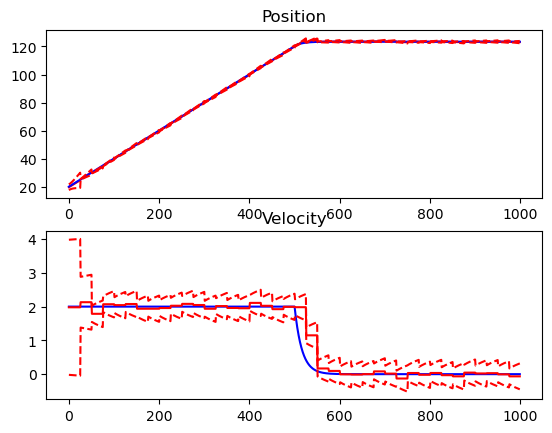

In [3]:

plt.ion()
plt.figure()

real_x = 20.0
meas_variance = 0.02
real_v = 2

kf = KF(initial_x=19.8, initial_v=1.98, accel_variance=0.1)

time_steps = 0.1
num_steps = 1000
meas_steps = 25

mus = []
covs = []
real_xs = []
real_vs = []


for step in range(num_steps):
    
    if step>500:
        real_v = real_v *0.94
          
    covs.append(kf.cov)
    mus.append(kf.mean)

    real_x = real_x + time_steps * real_v

    kf.predict(dt=time_steps)
    if step != 0 and step % meas_steps == 0:
        kf.update(meas_value=real_x + np.random.randn() * np.sqrt(meas_variance),
                  meas_variance=meas_variance)
    real_xs.append(real_x)
    real_vs.append(real_v)

plt.subplot(2, 1, 1)
plt.title('Position')
plt.plot([mu[0] for mu in mus], 'r')
plt.plot(real_xs, 'b')
plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 1, 2)
plt.title('Velocity')
plt.plot(real_vs, 'b')
plt.plot([mu[1] for mu in mus], 'r')
plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')

In [5]:
# offsets of each variable in the state Vector
iDx = 0
iDy = 1
iVx = 2
iVy = 3
numvars = max(iDx,iDy,iVx,iVy) + 1

class KF:
    def __init__(self, initial_x, 
                       initial_v,
                       accel_variance) -> None:
        
        # mean of state GRV
        self._x = np.zeros(numvars).reshape(numvars,1)
        self._x[iDx] = initial_x[0]
        self._x[iDy] = initial_x[1]
        self._x[iVx] = initial_v[0]
        self._x[iVy] = initial_v[1]
        
        
        self._accel_variance = np.array([[accel_variance,0],[0,accel_variance]])

        # covariance of state GRV
        self._P = np.eye(numvars)
        

    def predict(self, dt: float) -> None:
        # x = F x
        # P = F P Ft + G Gt a
        F = np.eye(numvars)
        F[iDx,iVx] = dt
        F[iDy,iVy] = dt
        
        new_x = F.dot(self._x)
        

        G = np.zeros((4,2)) 
        G[iDx,iDx] =G[iDy,iDy] = dt**2/2
        G[iVx,iDx]= G[iVy,iDy] = dt

        new_P = F.dot(self._P).dot(F.T) + G.dot(self._accel_variance).dot(G.T)

        self._P = new_P
        self._x = new_x

    def update(self, meas_value, meas_variance):
        # y = z - H x
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + K y
        # P = (I - K H) * P

        H = np.concatenate((np.eye(2),np.zeros((2,2))),axis=1)

        z = meas_value #2x1 [[mDx],[mDy]]
        R = meas_variance #2x2 [[sigma_x^2, 0], [0, sigma_y^2]]

        y = z - H.dot(self._x)
        S = H.dot(self._P).dot(H.T) + R

        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        new_x = self._x + K.dot(y)
        new_P = (np.eye(4) - K.dot(H)).dot(self._P)

        self._P = new_P
        self._x = new_x

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return self._x[iX]

    @property
    def vel(self) -> float:
        return self._x[iV]




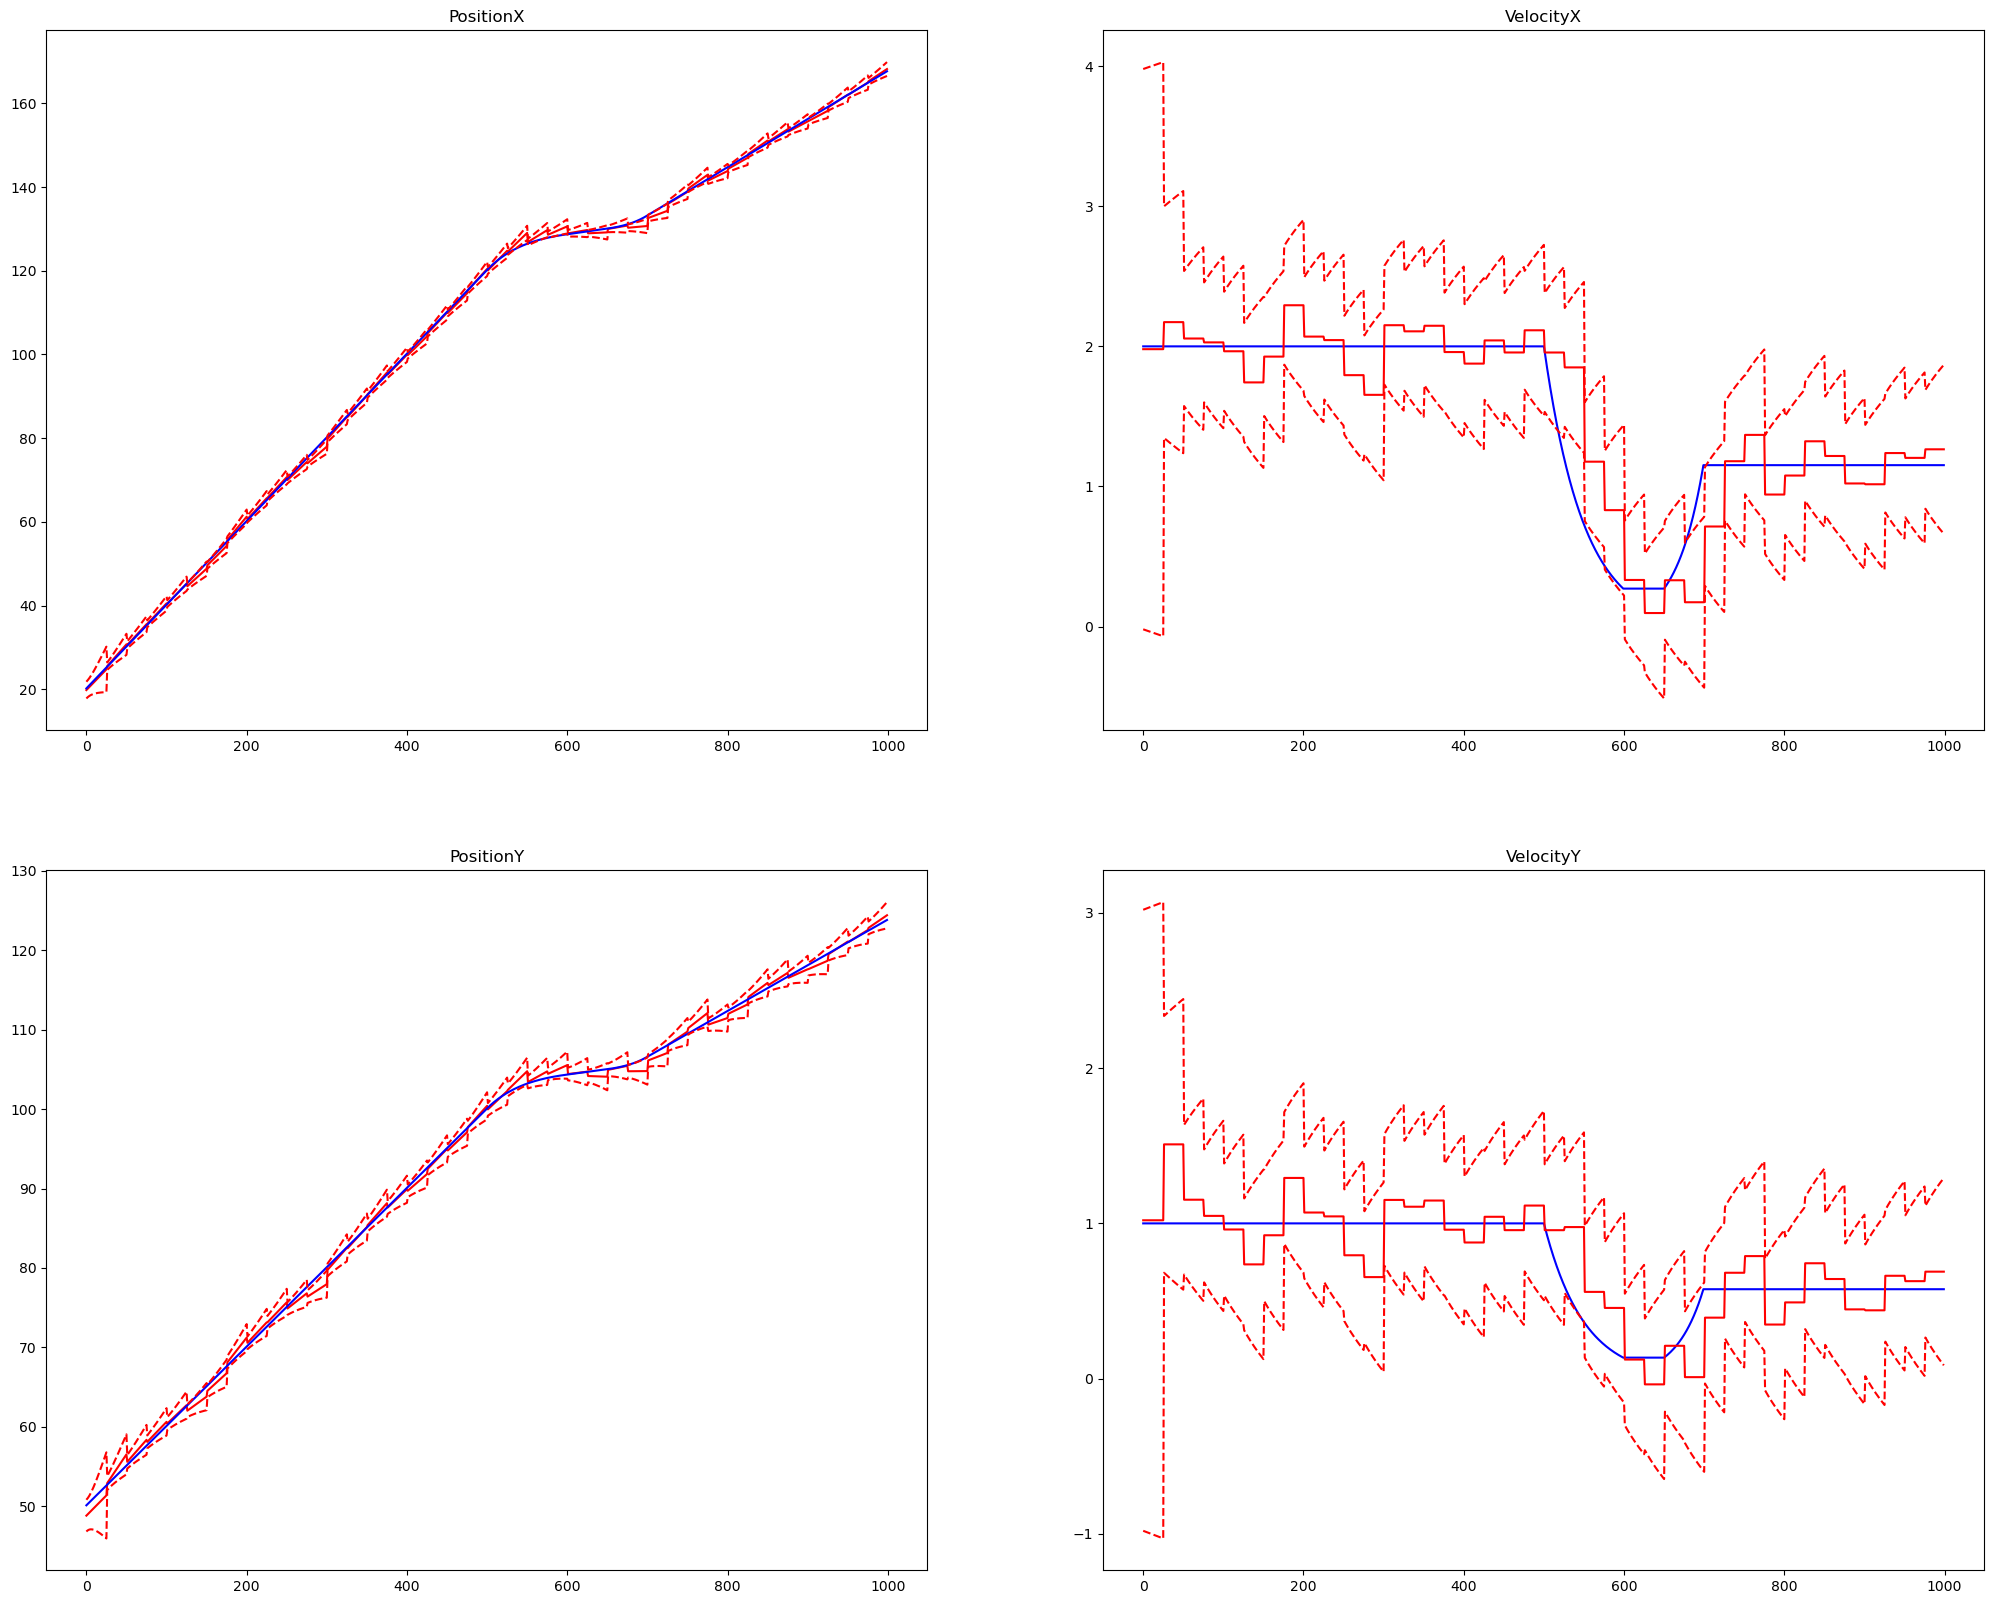

In [117]:
plt.ion()
plt.figure(figsize=(25,20))

real_x = np.array([[20],[50]])
sigma_meas = 0.2
meas_variance = np.array([[sigma_meas,0],[0,sigma_meas]])
real_v = np.array([[2],[1]])

kf = KF(initial_x=np.array([[19.8],[48.8]]), 
        initial_v=np.array([[1.98],[1.02]]), 
        accel_variance=0.2)

time_steps = 0.1
num_steps = 1000
meas_steps = 25

mus = []
covs = []
real_xs = []
real_vs = []


for step in range(num_steps):
    
    if step>500 and step<600:
        real_v = real_v *0.98
    if step>650 and step<700:
        real_v = real_v * 1.03
          
    covs.append(kf.cov)
    mus.append(kf.mean)

    real_x = real_x + time_steps * real_v

    kf.predict(dt=time_steps)
    if step != 0 and step % meas_steps == 0:
        kf.update(meas_value=real_x + np.random.randn() * np.sqrt(sigma_meas),
                  meas_variance=meas_variance)
    real_xs.append(real_x)
    real_vs.append(real_v)
    
real_xs = np.array(real_xs)
real_vs = np.array(real_vs)
    
plt.subplot(2, 2, 1)
plt.title('PositionX')
plt.plot([mu[0] for mu in mus], 'r')
plt.plot(real_xs[:,0], 'b')
plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 2)
plt.title('VelocityX')
plt.plot(real_vs[:,0], 'b')
plt.plot([mu[2] for mu in mus], 'r')
plt.plot([mu[2] - 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[2] + 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 3)
plt.title('PositionY')
plt.plot([mu[1] for mu in mus], 'r')
plt.plot(real_xs[:,1], 'b')
plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 4)
plt.title('VelocityY')
plt.plot(real_vs[:,1], 'b')
plt.plot([mu[3] for mu in mus], 'r')
plt.plot([mu[3] - 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--')
plt.plot([mu[3] + 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--')